<a href="https://colab.research.google.com/github/taliafabs/LogisticVoteChoice/blob/main/code/ces_midterm_modeling_extension_2016.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Applying the model to the 2016 CCES Dataset

The model was modified slightly for application to the 2016 CCES dataset. The `urbancity` variable is not available, nor is the information required to encode it, in the 2016 CCES survey dataset. As a result, the `urbancity` and `race x urbancity` predictors were omitted.

The 2016 CCES dataset was obtained from Harvard Dataverse: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910/DVN/GDF6Z0

The model applied to the 2016 dataset is as follows:
\begin{align*}
\texttt{vote_trump} &=  \beta_0 + \beta_1 \cdot \texttt{age_bracket} + \beta_2 \cdot \texttt{gender} + \beta_3 \cdot \texttt{educ} + \beta_4 \cdot \texttt{state} \\
&+ \beta_5 \cdot \texttt{region}  + \beta_6 \cdot \texttt{trump_approval} + \beta_7 \cdot \texttt{econ_past_year} \\
&+ \beta_8 \cdot \texttt{family_income_past_year} + \beta_{9} \cdot (\texttt{race $\times$ region}) \\
& + \beta_{10} \cdot (\texttt{race} \times \texttt{education}) + \beta_{11} \cdot (\texttt{race} \times \texttt{gender})
\end{align*}


In [ ]:
# --- WORKPLACE SETUP ---
# Note: I used ChatGPT to re-format/organize this chunk.

# --- Core Libraries ---
import os
import random
import tempfile

# --- Data Handling ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# --- Stats and Modeling ---
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from scipy.stats.distributions import chi2

# --- Machine Learning ---
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Deep Learning ---
import tensorflow as tf
from tensorflow import keras
from keras import regularizers

# --- Bayesian Modeling ---
import pymc as pm
import arviz as az

In [ ]:
ces16_dummies = pd.read_parquet("https://github.com/taliafabs/LogisticVoteChoice/raw/3c2c3eb0102607d2f4ced647238b7e09a97ac5f4/data/ces16_analysis_dummies.parquet", engine="pyarrow")


In [ ]:
ces16_dummies.head()

,vote_clinton,vote_trump,age_bracket_25–34,age_bracket_35–44,age_bracket_45–54,age_bracket_55–64,age_bracket_65–74,age_bracket_75+,race_Black,race_Hispanic,...,White_Some college,Black_Northeast,Black_South,Black_West,Hispanic_Northeast,Hispanic_South,Hispanic_West,White_Northeast,White_South,White_West
0,0,1,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,0,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,1,0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
6,0,1,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
8,0,1,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
ces16_df = ces16_dummies.drop(columns=["vote_clinton"])

In [ ]:
# train and test
train_dataset = ces16_df.sample(frac=0.75, random_state=0)
test_dataset = ces16_df.drop(train_dataset.index)

X_train, y_train = train_dataset.drop('vote_trump', axis=1), train_dataset['vote_trump']
X_test, y_test = test_dataset.drop('vote_trump', axis=1), test_dataset['vote_trump']

In [ ]:
# define the logistic model architecture (extremely similar to midterm paper)
logistic_model = keras.Sequential([
    keras.layers.Dense(1,
                       activation='sigmoid',
                       input_shape=(X_train.shape[1],),
                       kernel_regularizer = regularizers.l2(0.001) # l2 regularization and lambda penalty
                       )
])

# compile model SGD, learning rate 0.01, batch size 32, 100 epochs
logistic_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), # learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# fit it
history = logistic_model.fit(X_train, y_train,
                             epochs=50, # reduce number of epochs from midterm paper
                             batch_size=32,
                             validation_data=(X_test, y_test),
                             verbose=0)

y_pred_prob = logistic_model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)
print(classification_report(y_test, y_pred, digits=4)) # round this to 4 decimal places

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0     0.9379    0.9410    0.9394      5438
           1     0.9301    0.9264    0.9282      4607

    accuracy                         0.9343     10045
   macro avg     0.9340    0.9337    0.9338     10045
weighted avg     0.9343    0.9343    0.9343     10045



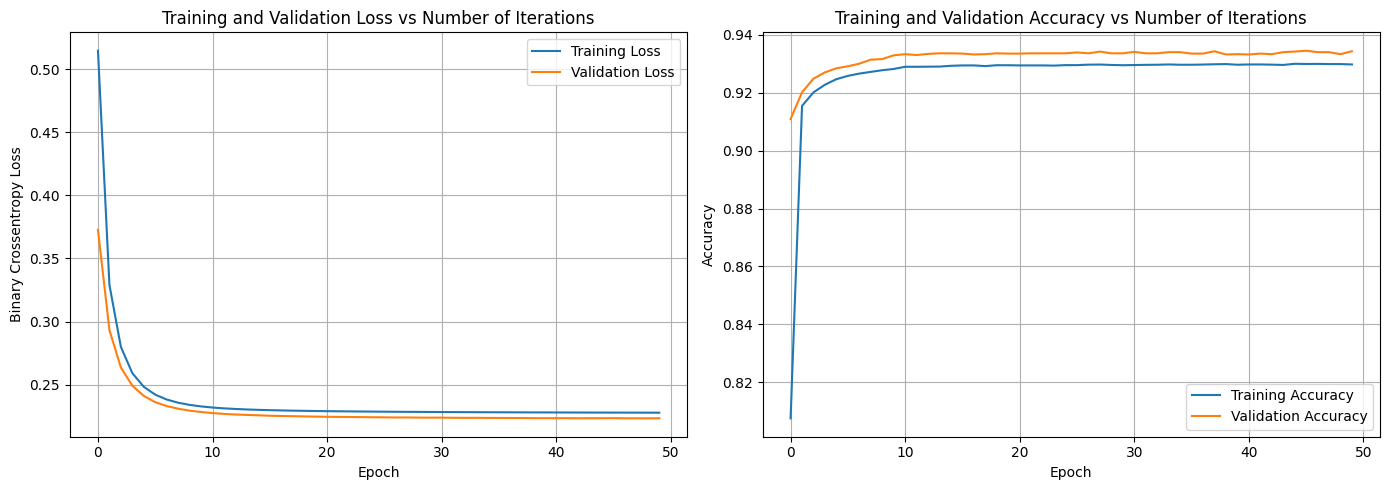

In [ ]:
# I asked chatgpt how to plot training and validation accuracy side by side

# Create 1 row, 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# --- Loss Plot ---
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Binary Crossentropy Loss')
axs[0].set_title('Training and Validation Loss vs Number of Iterations')
axs[0].legend()
axs[0].grid(True)

# --- Accuracy Plot ---
axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Validation Accuracy vs Number of Iterations')
axs[1].legend()
axs[1].grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()